Two graphs are said to be isomorphic if there is a one-to-one correspondence between their nodes such that the edges are preserved. In simpler terms, two graphs are isomorphic if you can rename the nodes of one graph to match the nodes of the other graph in such a way that the edge relationships are the same.

For example, consider two graphs:

Graph 1: A -- B -- C

Graph 2: X -- Y -- Z

These two graphs are isomorphic because you can rename A to X, B to Y, and C to Z, and the edge relationships remain the same. 

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
from networkx.algorithms import isomorphism

In [2]:
import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
import random
import itertools
import time
import csv

In [3]:
def solve_max_cut(n,edges):
    # Define the variables and constraints
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0]
    constraints += [X[i, i] == 1 for i in range(n)]

    # Define the objective function
    objective = sum(0.5 * (1 - X[i, j]) for (i, j) in edges)

    # Create the optimization problem
    prob = cp.Problem(cp.Maximize(objective), constraints)

    # Solve the problem
    prob.solve()
    # Retrieve the optimal solution and assign values to vertices
    x = sqrtm(X.value)
    u = np.random.randn(n)
    x = np.sign(x @ u)
    # Print the optimal cut value
    print("cvxpy Cut Value:", prob.value)
    return prob.value

In [4]:
def calculate_cut_size(graph, node_assignment):
    cut_size = 0
    for edge in graph:
        u, v = edge
        if node_assignment[u] != node_assignment[v]:
            cut_size += 1
    return cut_size

def find_maximum_cut(edges):
    nodes = set(itertools.chain(*edges))
    best_cut_size = 0
    best_assignment = None
    '''
    This generates all possible combinations of the values 1 and -1 for each node in the graph.
    For example, if there are 3 nodes, it will produce (1, 1, 1), (1, 1, -1), (1, -1, 1), ..., (-1, -1, -1).
    '''
    for assignment in itertools.product([1, -1], repeat=len(nodes)):
        node_assignment = dict(zip(nodes, assignment))
        cut_size = calculate_cut_size(edges, node_assignment)
        if cut_size > best_cut_size:
            best_cut_size = cut_size
            best_assignment = node_assignment
    print('greedy Cut Value',best_cut_size)
    return best_assignment, best_cut_size

In [5]:
def save_results_to_csv(results, csv_filename):
    """
    Save results to a CSV file.

    Parameters:
    - results: List of dictionaries containing results.
    - csv_filename: Name of the CSV file to save.
    """
    with open(csv_filename, 'w', newline='') as csvfile:
        fieldnames = results[0].keys()
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for result in results:
            writer.writerow(result)

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

# make_graphs function
This function generates all possible graphs with n nodes recursively. Each graph is represented as a list of edges, and the edges are constructed in lexicographical order.

In [7]:
def make_graphs(n=2, i=None, j=None, start_time=None, limit_time=None):
    """Make a graph recursively, by either including or skipping each edge.
    Edges are given in lexicographical order by construction."""
    out = []

    # Get the current time
    current_time = datetime.now()

    # Check if the limit_time is reached
    if start_time is not None and limit_time is not None:
        elapsed_time = current_time - start_time
        if elapsed_time >= limit_time:
            return out

    if i is None:  # First call
        out = [[(0, 1)] + r for r in make_graphs(n=n, i=0, j=1, start_time=start_time, limit_time=limit_time)]
    elif j < n - 1:
        out += [[(i, j + 1)] + r for r in make_graphs(n=n, i=i, j=j + 1, start_time=start_time, limit_time=limit_time)]
        out += [r for r in make_graphs(n=n, i=i, j=j + 1, start_time=start_time, limit_time=limit_time)]
    elif i < n - 1:
        out = make_graphs(n=n, i=i + 1, j=i + 1, start_time=start_time, limit_time=limit_time)
    else:
        out = [[]]

    return out

# connected function
This function checks if a given graph is fully connected using Union-Find. It uses a Union-Find data structure to determine whether all nodes in the graph are part of the same connected component.

In [8]:
def connected(g):
    """Check if the graph is fully connected, with Union-Find."""
    nodes = set([i for e in g for i in e])
    roots = {node: node for node in nodes}

    def _root(node, depth=0):
        if node == roots[node]:
            return (node, depth)
        else:
            return _root(roots[node], depth + 1)

    for i, j in g:
        ri, di = _root(i)
        rj, dj = _root(j)
        if ri == rj:
            continue
        if di <= dj:
            roots[ri] = rj
        else:
            roots[rj] = ri
    return len(set([_root(node)[0] for node in nodes])) == 1

# generate_connected_graphs function
This function generates all possible connected graphs with a specified number of nodes (N). It uses the make_graphs function and filters out the graphs that are not fully connected using the connected function.

In [9]:
def generate_connected_graphs(N):
    """Generate all possible connected graphs with N nodes."""
    graphs = make_graphs(N)
    connected_graphs = [g for g in graphs if connected(g)]
    return connected_graphs

# perm function
This function generates all permutations of n elements. It is a recursive function that uses backtracking to generate all possible permutations.

In [10]:
def perm(n, s=None):
    """All permutations of n elements."""
    if s is None:
        return perm(n, tuple(range(n)))
    if not s:
        return [[]]
    return [[i] + p for i in s for p in perm(n, tuple([k for k in s if k != i]))]

# permute function
Given a graph g and the number of nodes n, this function creates a set of all possible isomorphic codes for the graph. The isomorphic codes are represented as hashable tuples, where each edge is represented as a tuple with nodes sorted lexicographically.

In [11]:
def permute(g, n):
    """Create a set of all possible isomorphic codes for a graph,
    as nice hashable tuples. All edges are i<j, and sorted lexicographically."""
    ps = perm(n)
    out = set([])
    for p in ps:
        out.add(
            tuple(sorted([(p[i], p[j]) if p[i] < p[j] else (p[j], p[i]) for i, j in g]))
        )
    return list(out)

# filter function
This function filters out improper graphs based on certain criteria. It filters graphs that have an incorrect number of nodes, are not fully connected, or are isomorphic to previously considered graphs. It uses a set (mem) to keep track of isomorphic graphs and ensures that each graph in the result (gs2) is unique up to isomorphism.

In [15]:
def filter(gs, target_nv):
    """Filter all improper graphs: those with not enough nodes,
    those not fully connected, and those isomorphic to previously considered."""
    mem = set({})
    gs2 = []
    for g in gs:
        nv = len(set([i for e in g for i in e]))
        if nv != target_nv:
            continue
        if not connected(g):
            continue
        if tuple(g) not in mem:
            gs2.append(g)
            mem |= set(permute(g, target_nv))
    return gs2

# plot_graphs function
A utility function to plot a set of graphs using Networkx and Matplotlib. It takes an array of graphs and plots each graph using the Kamada-Kawai layout.

In [13]:
def plot_graphs(graphs, figsize=14, dotsize=20):
    """Utility to plot a lot of graphs from an array of graphs.
    Each graphs is a list of edges; each edge is a tuple."""
    n = len(graphs)
    fig = plt.figure(figsize=(figsize, figsize))
    fig.patch.set_facecolor("white")  # To make copying possible (white background)
    k = int(np.sqrt(n))
    for i in range(n):
        plt.subplot(k + 1, k + 1, i + 1)
        g = nx.Graph()  # Generate a Networkx object
        for e in graphs[i]:
            g.add_edge(e[0], e[1])
        nx.draw_kamada_kawai(g, node_size=dotsize)
        print(".", end="")



......

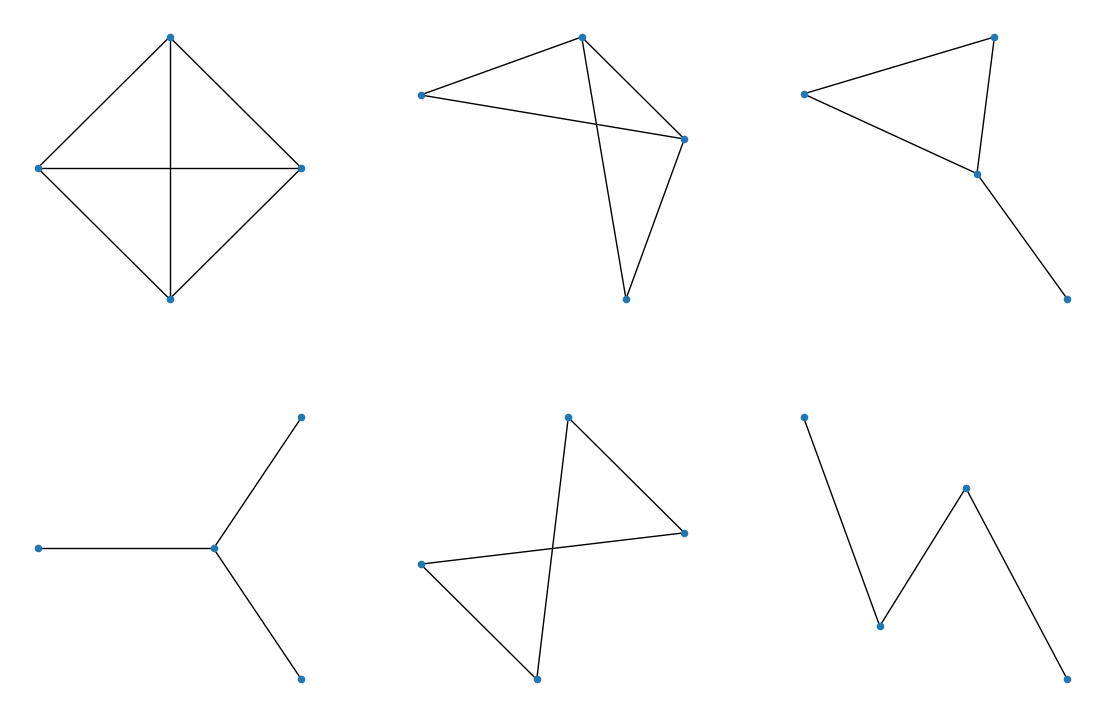

In [16]:
# Main body
NV = 4
gs = make_graphs(NV)
gs = filter(gs, NV)
plot_graphs(gs, figsize=14, dotsize=20)

.....................

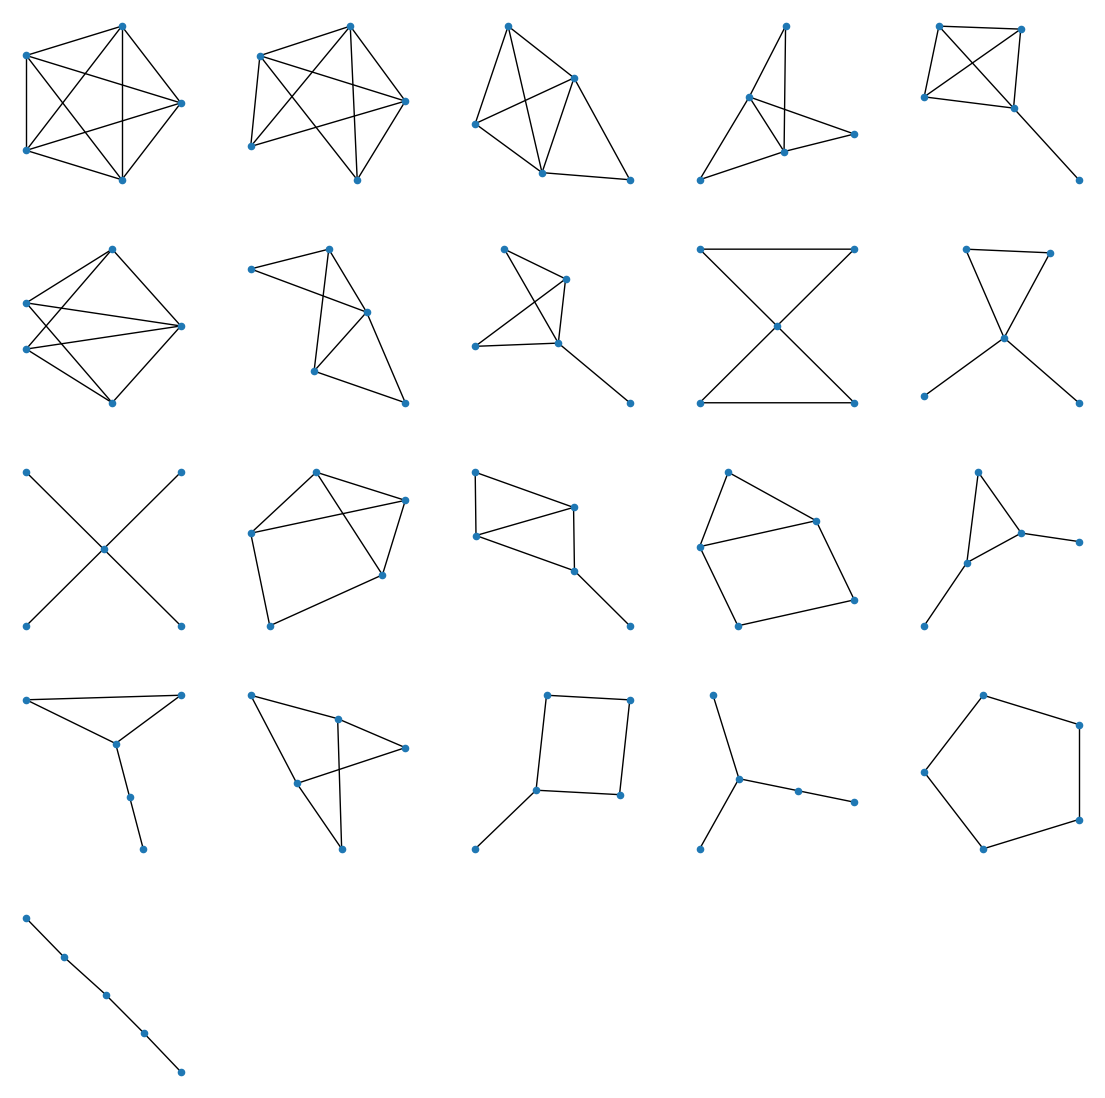

In [17]:
# Main body
NV = 5
gs = make_graphs(NV)
gs = filter(gs, NV)
plot_graphs(gs, figsize=14, dotsize=20)

# Main Function

In [ ]:
def process_graphs(max_time_minutes=5):
    results = []
    N = 4
    start_time = time.time()
    while True:
        gs = make_graphs(N)
        gs = filter(gs, N)
        plot_graphs(gs, figsize=14, dotsize=20)
        # Print or visualize the connected graphs
        for i, graph in enumerate(gs):
            edges=graph
            print(edges)
            # Calculate the cut size using the find_maximum_cut function
            node_assignment, cut_size_greedy = find_maximum_cut(edges)
            # Record the results
            result = {
                'n': N,
                'edges': edges,
                'cut_size_greedy': cut_size_greedy,
                'node_assignment': node_assignment
#                 'cut_size_cvxpy': cut_size_cvxpy
            }
            print(result)
            results.append(result)

        # Check if the elapsed time exceeds the maximum time limit
        elapsed_time = time.time() - start_time
        print('this is elapsed time ' ,elapsed_time)
        if elapsed_time >= max_time_minutes * 60:
            break
            
        # Update the start time for the next iteration
        start_time = time.time()
        # Increment the number of nodes for the next iteration
        N += 1
        print(N)
        if N==31:
            break
    return results

In [ ]:
# Example usage:
csv_filename = 'TestData30.csv'
#deep_unfolding
results = process_graphs(60)
save_results_to_csv(results, csv_filename)